In [2]:
import os
import shutil
import cv2
from random import sample
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

2022-11-11 11:00:46.914393: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#cocaine_sample = sample(os.listdir(os.path.join("data","extracted_images","cocaine")),3000)
#other_sample = sample(os.listdir(os.path.join("data","extracted_images","other")),3000)

In [4]:
#for image in cocaine_sample:
#    src = os.path.join("data","extracted_images","cocaine",image)
#    dst = os.path.join("data","model","cocaine",image)
#    shutil.copy(src,dst)
    
#for image in other_sample:
#    src = os.path.join("data","extracted_images","other",image)
#    dst = os.path.join("data","model","other",image)
#    shutil.copy(src,dst)    

In [5]:
for file in os.listdir(os.path.join("data","extracted_images","other")):
    if file == ".DS_Store":
        os.remove(os.path.join("data","extracted_images","other",file))
    else:
        pass

for file in os.listdir(os.path.join("data","extracted_images","cocaine")):
    if file == ".DS_Store":
        os.remove(os.path.join("data","extracted_images","cocaine",file))
    else:
        pass

In [6]:
l_c = []
for i in os.listdir(os.path.join("data","extracted_images","cocaine")):
    l_c.append(i.split(".")[1])
l_c = list(set(l_c))

l_o = []
for i in os.listdir(os.path.join("data","extracted_images","other")):
    l_o.append(i.split(".")[1])
l_o = list(set(l_o))

print(l_o, l_c)

['jpg'] ['jpg']


In [7]:
# Creates a pipeline to grab all images under data folder 
data = tf.keras.utils.image_dataset_from_directory("data/extracted_images", batch_size=64)

Found 23372 files belonging to 2 classes.


2022-11-11 11:00:58.465328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Provides the possibility to iterate over the data 
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
batch[0].shape

(64, 256, 256, 3)

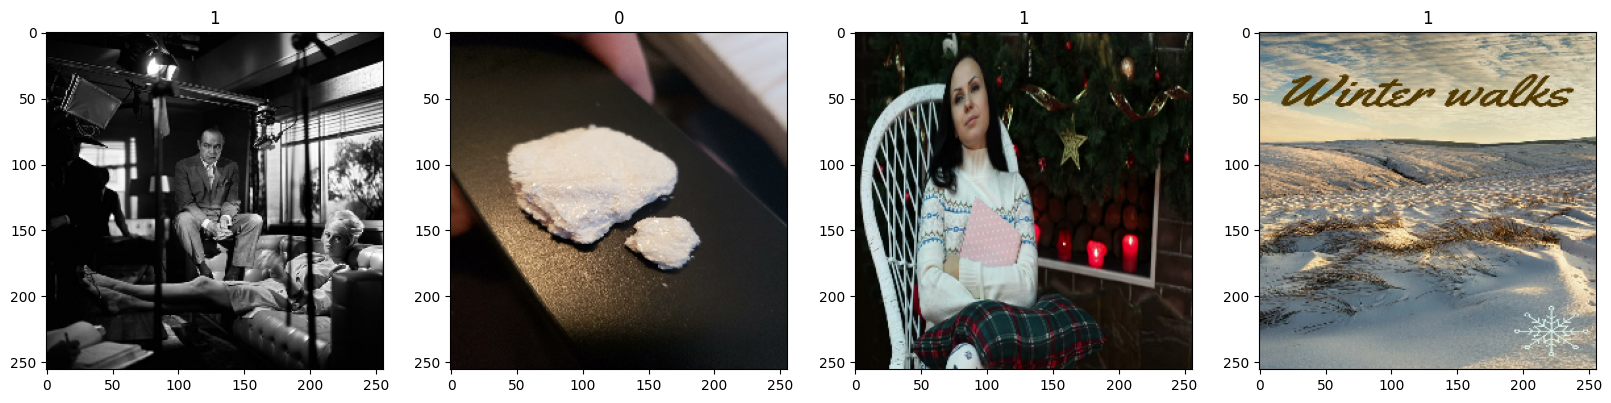

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [10]:
# 1 = Other
# 0 = Cocaine

In [11]:
data = data.map(lambda x,y: (x/255,y))

In [12]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

In [13]:
batch[0].max()

1.0

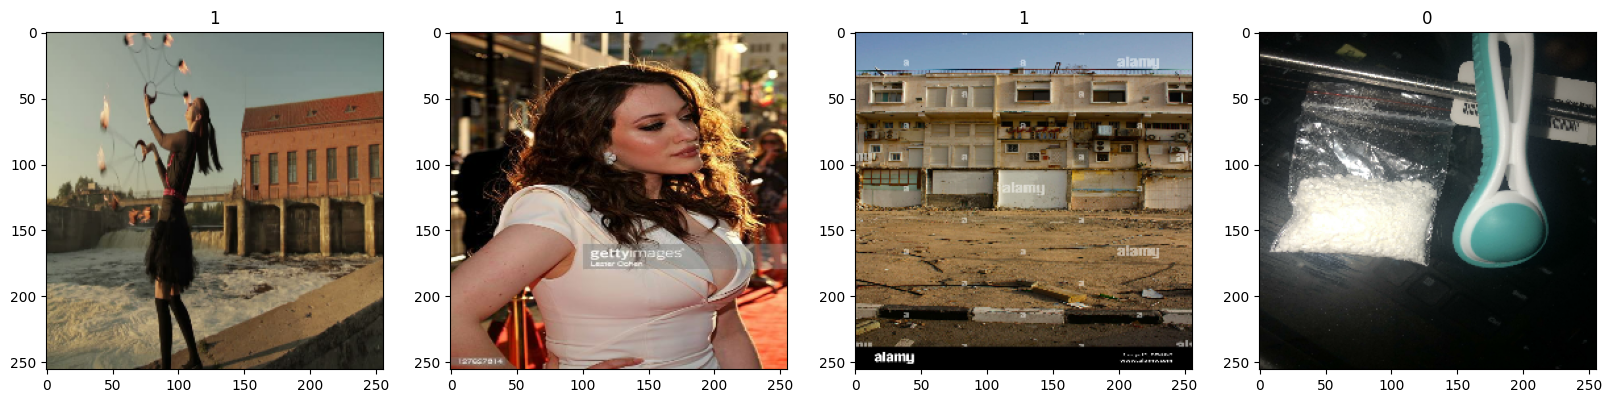

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [15]:
len(data)

366

In [16]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)
print(train_size, val_size, test_size)

256 74 36


In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [19]:
model = Sequential()
model.add(Conv2D(32, (3,3), 1, activation = "relu", input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation = "relu"))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = "relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [20]:
model.compile("adam", loss = tf.losses.BinaryCrossentropy(), metrics = ["accuracy"])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

In [22]:
logdir = 'model/logs'
tensorboard_callbacks = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [23]:
hist = model.fit(train, epochs=3, validation_data=val, callbacks=[tensorboard_callbacks])

Epoch 1/3
 16/256 [>.............................] - ETA: 8:04 - loss: 0.8242 - accuracy: 0.5576


KeyboardInterrupt



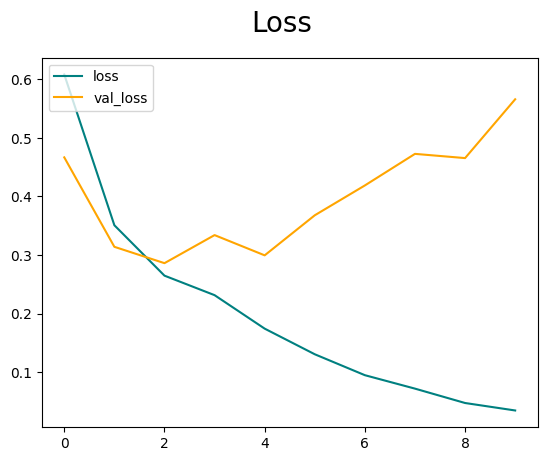

In [23]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')

fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

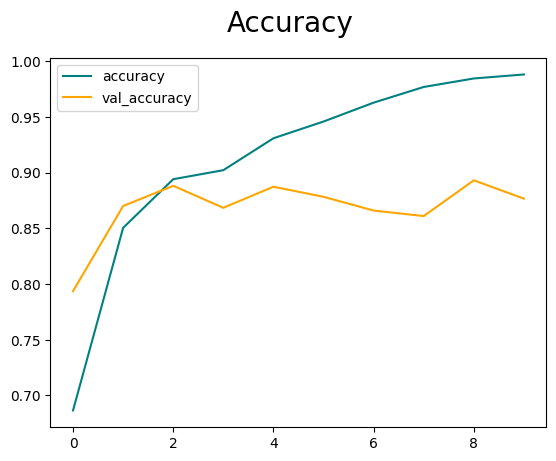

In [24]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')

fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [25]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [26]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [27]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 181ms/step


In [28]:
print(pre.result().numpy(), re.result().numpy(), acc.result().numpy())

0.875 0.85714287 0.8682432


In [1]:
folder = "cocaine"
img = sample(os.listdir(os.path.join("data","extracted_images",folder)),1)
img = os.path.join("data","extracted_images",folder,"".join(img))
img = cv2.imread(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

NameError: name 'sample' is not defined

In [52]:
resize = tf.image.resize(img, (256,256))
yhat = model.predict(np.expand_dims(resize/255, 0))

if yhat > 0.5:
    print(f"Predicted class is not Cocaine {yhat[0][0]}")
else:
    print(f"Predicted class is Cocaine {yhat[0][0]}")

1/1 [==============================] - 0s 23ms/step
Predicted class is Cocaine 0.007326110731810331
